In [34]:
#This notebook performs Step 1 of the RNN training process: time-warping the single letter data so that it
#can be used to initialize the data-labeling HMM. Running this notebook will (slowly) time-warp all 10 sessions
#and save the results in Step1_TimeWarping folder.

#To run this notebook, you'll need the time warped PCA python package (https://github.com/ganguli-lab/twpca).

In [35]:
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()

#suppress all tensorflow warnings (largely related to compatability with v2)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import os
import numpy as np
import scipy.io
import scipy.ndimage.filters
import matplotlib.pyplot as plt
from twpca import TWPCA
from twpca.regularizers import curvature

#point this towards the top level dataset directory
rootDir = os.path.expanduser('~') + '/clones/willets-2021-handwriting-bci'

#this line ensures that tensorflow will only use GPU 0 (keeps it from taking over all the GPUs in a multi-gpu setup)
os.environ["CUDA_VISIBLE_DEVICES"]='0'

#defines all the sessions that will be time-warped
dataDirs = ['t5.2019.05.08']

#saves all time-warped data in this folder
if not os.path.isdir(rootDir + '/warped-data'):
    os.mkdir(rootDir + '/warped-data')

In [36]:
#--Can add new definitions here to apply this code to other problems or datasets.--
import numpy as np

def getHandwritingCharacterDefinitions():
    """
    Returns a dictionary with entries that define the names of each character, its length, and where the pen tip begins.
    
    Returns:
        charDef (dict)
    """
        
    charDef = {}
    
    #Define the list of all 31 characters and their names.
    charDef['charList'] = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z',
                'greaterThan','comma','apostrophe','tilde','questionMark']
    charDef['charListAbbr'] = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z',
                '>',',',"'",'~','?']

    #Define the length of each character (in # of 10 ms bins) to use for each template.
    #These were hand-defined based on visual inspection of the reconstructed pen trajectories.
    charDef['charLen'] = np.array([99, 91, 70, 104, 98, 125, 110, 104, 79, 92, 127, 68, 132, 90, 
                        84, 113, 104, 74, 86, 110, 86, 83, 110, 103, 115, 100, 82, 77, 116, 71, 110]).astype(np.int32)
    
    #For each character, this defines the starting location of the pen tip (0 = bottom of the line, 1 = top)
    charDef['penStart'] = [0.25, 1, 0.5, 0.5, 0.25, 1.0, 0.25, 1.0, 0.5, 0.5, 1, 1, 0.5, 0.5, 0.25, 0.5, 0.25, 0.5, 0.5, 1, 
           0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.25, 1, 0.5, 1]
    
    #dictionary to convert string representation to character index
    charDef['strToCharIdx'] = {}
    for x in range(len(charDef['charListAbbr'])):
        charDef['strToCharIdx'][charDef['charListAbbr'][x]] = x
        
    #ordering of characters that kaldi (i.e., the language model) expects
    charDef['kaldiOrder'] = ['<ctc>','>',"'",',','.','?','a','b','c','d','e','f','g','h','i','j',
                             'k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
    
    #re-indexing to match kaldi order (e.g., outputs[:,:,charDef['idxToKaldi']] places the output in kald-order)
    charDef['idxToKaldi'] = np.array([31,26,28,27,29,30,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,
                                     21,22,23,24,25]).astype(np.int32)
    
    return charDef

charDef = getHandwritingCharacterDefinitions()

In [37]:
import tarfile
# Path to the tar file and the target file inside it
tar_path = 'handwritingBCIData.tar'
target_mat_path = './handwritingBCIData/Datasets/t5.2019.05.08/singleLetters.mat'

# Open the tar file
with tarfile.open(tar_path, 'r') as tar:
    # Get the file object
    mat_member = tar.getmember(target_mat_path)
    mat_file = tar.extractfile(mat_member)
    
    # Load the .mat file
    if mat_file is not None:
        dat = scipy.io.loadmat(mat_file)

Warping dataset: t5.2019.05.08
Warping character: a


/var/folders/n_/8p1gdnb570j4m06ltsyf5d1w0000gn/T/ipykernel_77119/1300111360.py:54: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  smoothed_spikes = scipy.ndimage.filters.gaussian_filter1d(dat['neuralActivityCube_'+char], 3.0, axis=1)
2025-06-17 10:00:23.023864: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_scale_68/Assign' id:1760288 op device:{requested: '', assigned: ''} def:{{{node tau_scale_68/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](tau_scale_68, tau_scale_68/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-17 10:01:44.957420: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_shift_68/A

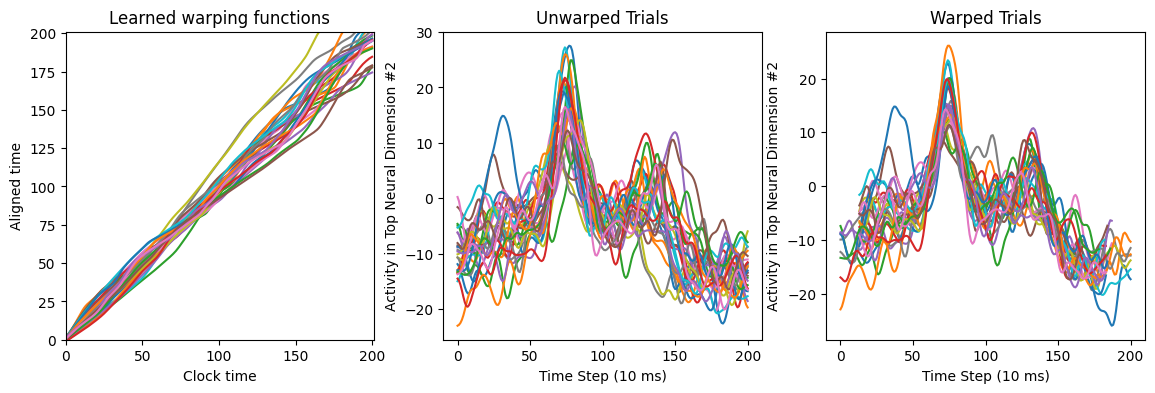

Warping character: b


/var/folders/n_/8p1gdnb570j4m06ltsyf5d1w0000gn/T/ipykernel_77119/1300111360.py:54: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  smoothed_spikes = scipy.ndimage.filters.gaussian_filter1d(dat['neuralActivityCube_'+char], 3.0, axis=1)
2025-06-17 10:04:22.848493: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_scale_69/Assign' id:1788829 op device:{requested: '', assigned: ''} def:{{{node tau_scale_69/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](tau_scale_69, tau_scale_69/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-17 10:05:51.702392: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_shift_69/A

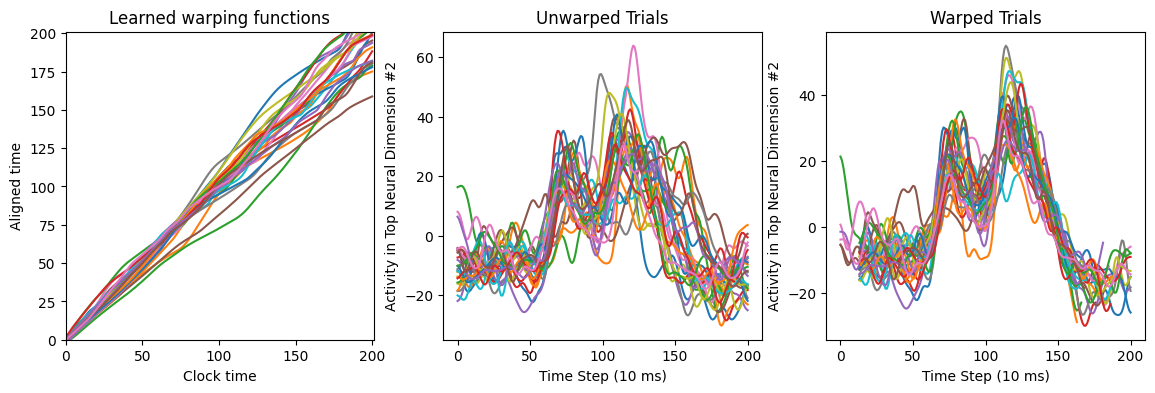

Warping character: c


/var/folders/n_/8p1gdnb570j4m06ltsyf5d1w0000gn/T/ipykernel_77119/1300111360.py:54: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  smoothed_spikes = scipy.ndimage.filters.gaussian_filter1d(dat['neuralActivityCube_'+char], 3.0, axis=1)
2025-06-17 10:08:32.890367: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_scale_70/Assign' id:1817421 op device:{requested: '', assigned: ''} def:{{{node tau_scale_70/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](tau_scale_70, tau_scale_70/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-17 10:09:57.402651: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_shift_70/A

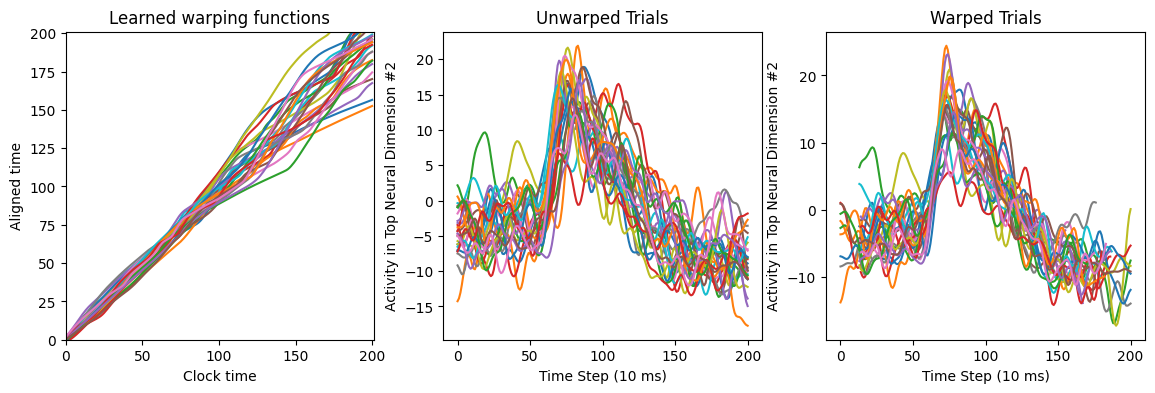

Warping character: d


/var/folders/n_/8p1gdnb570j4m06ltsyf5d1w0000gn/T/ipykernel_77119/1300111360.py:54: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  smoothed_spikes = scipy.ndimage.filters.gaussian_filter1d(dat['neuralActivityCube_'+char], 3.0, axis=1)
2025-06-17 10:12:28.699217: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_scale_71/Assign' id:1846064 op device:{requested: '', assigned: ''} def:{{{node tau_scale_71/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](tau_scale_71, tau_scale_71/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-17 10:13:57.249153: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_shift_71/A

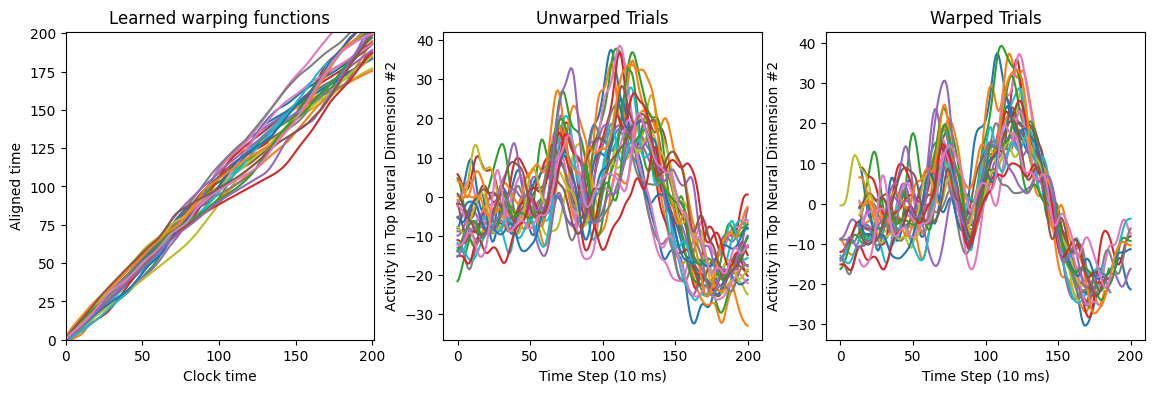

Warping character: e


/var/folders/n_/8p1gdnb570j4m06ltsyf5d1w0000gn/T/ipykernel_77119/1300111360.py:54: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  smoothed_spikes = scipy.ndimage.filters.gaussian_filter1d(dat['neuralActivityCube_'+char], 3.0, axis=1)
2025-06-17 10:16:45.466399: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_scale_72/Assign' id:1874758 op device:{requested: '', assigned: ''} def:{{{node tau_scale_72/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](tau_scale_72, tau_scale_72/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-17 10:40:52.185549: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_shift_72/A

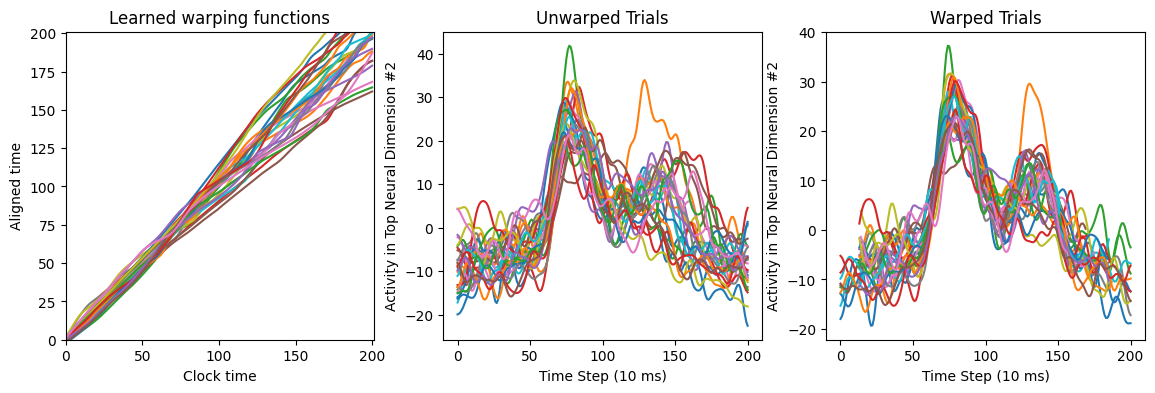

Warping character: f


/var/folders/n_/8p1gdnb570j4m06ltsyf5d1w0000gn/T/ipykernel_77119/1300111360.py:54: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  smoothed_spikes = scipy.ndimage.filters.gaussian_filter1d(dat['neuralActivityCube_'+char], 3.0, axis=1)
2025-06-17 11:29:19.939141: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_scale_73/Assign' id:1903503 op device:{requested: '', assigned: ''} def:{{{node tau_scale_73/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](tau_scale_73, tau_scale_73/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-17 11:30:42.865320: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_shift_73/A

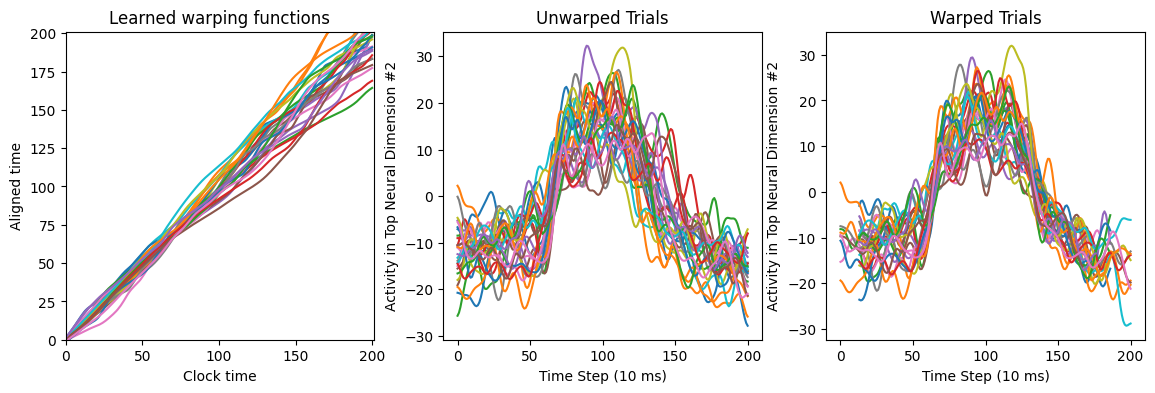

Warping character: g


/var/folders/n_/8p1gdnb570j4m06ltsyf5d1w0000gn/T/ipykernel_77119/1300111360.py:54: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  smoothed_spikes = scipy.ndimage.filters.gaussian_filter1d(dat['neuralActivityCube_'+char], 3.0, axis=1)
2025-06-17 11:33:25.789181: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_scale_74/Assign' id:1932299 op device:{requested: '', assigned: ''} def:{{{node tau_scale_74/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](tau_scale_74, tau_scale_74/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-17 11:35:03.648727: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_shift_74/A

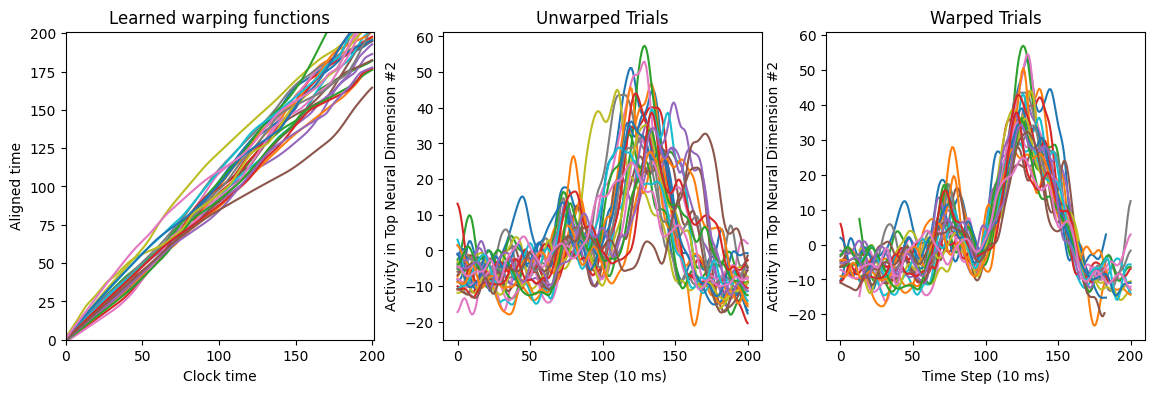

Warping character: h


/var/folders/n_/8p1gdnb570j4m06ltsyf5d1w0000gn/T/ipykernel_77119/1300111360.py:54: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  smoothed_spikes = scipy.ndimage.filters.gaussian_filter1d(dat['neuralActivityCube_'+char], 3.0, axis=1)
2025-06-17 11:38:00.051383: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_scale_75/Assign' id:1961146 op device:{requested: '', assigned: ''} def:{{{node tau_scale_75/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](tau_scale_75, tau_scale_75/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-17 11:39:32.962664: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_shift_75/A

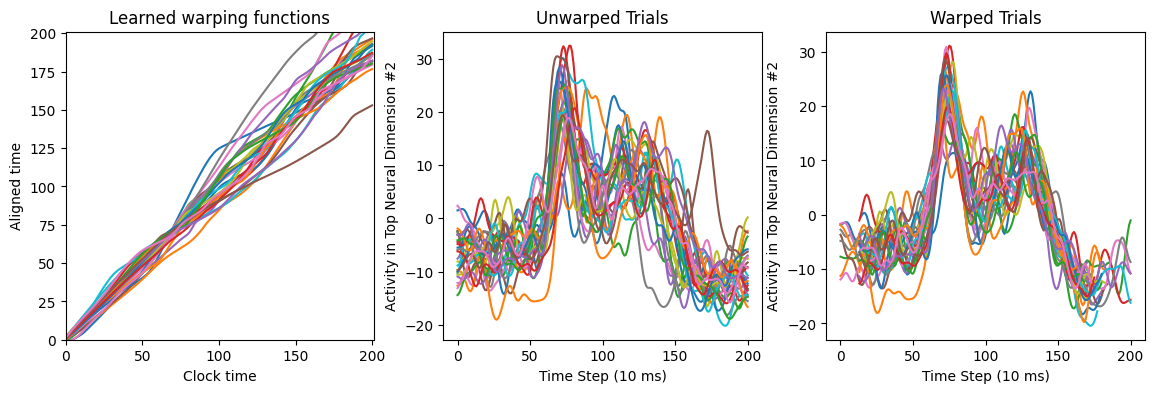

Warping character: i


/var/folders/n_/8p1gdnb570j4m06ltsyf5d1w0000gn/T/ipykernel_77119/1300111360.py:54: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  smoothed_spikes = scipy.ndimage.filters.gaussian_filter1d(dat['neuralActivityCube_'+char], 3.0, axis=1)
2025-06-17 11:42:26.376376: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_scale_76/Assign' id:1990044 op device:{requested: '', assigned: ''} def:{{{node tau_scale_76/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](tau_scale_76, tau_scale_76/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-17 11:43:55.694258: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_shift_76/A

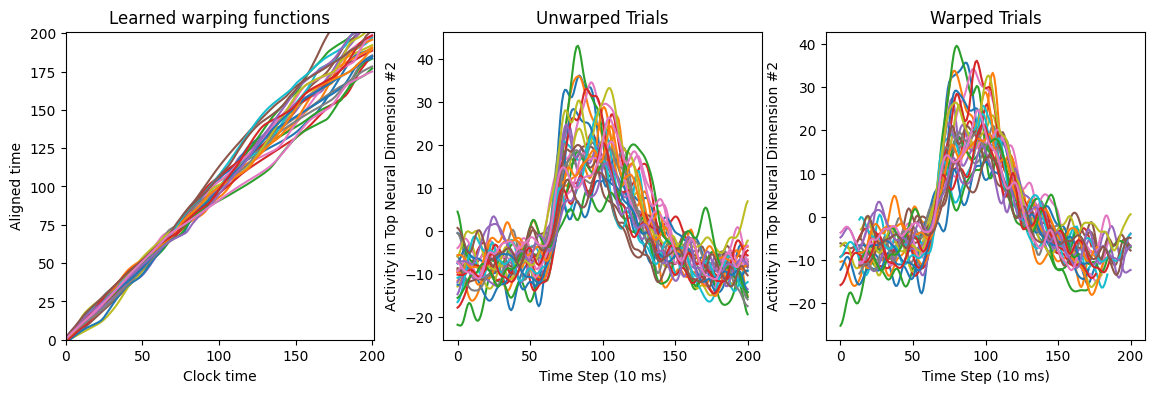

Warping character: j


/var/folders/n_/8p1gdnb570j4m06ltsyf5d1w0000gn/T/ipykernel_77119/1300111360.py:54: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  smoothed_spikes = scipy.ndimage.filters.gaussian_filter1d(dat['neuralActivityCube_'+char], 3.0, axis=1)
2025-06-17 11:46:57.392286: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_scale_77/Assign' id:2018993 op device:{requested: '', assigned: ''} def:{{{node tau_scale_77/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](tau_scale_77, tau_scale_77/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-17 11:48:40.710635: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_shift_77/A

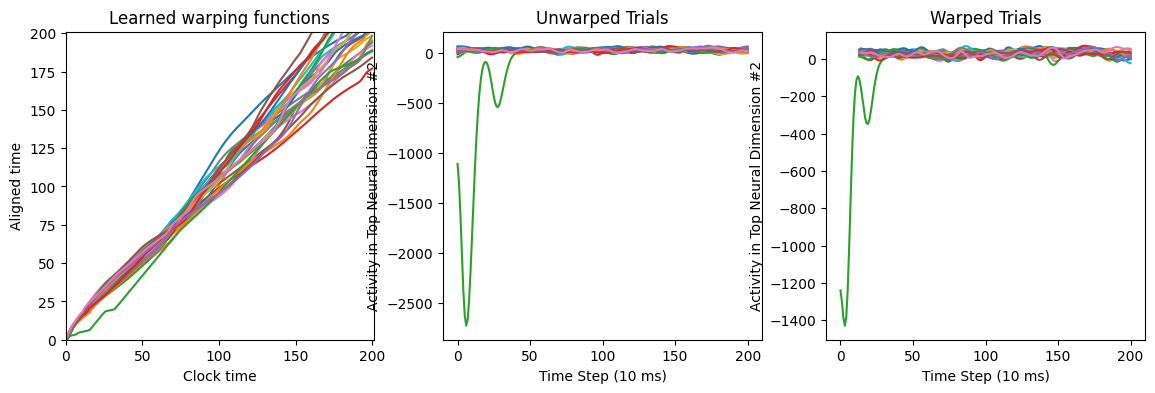

Warping character: k


/var/folders/n_/8p1gdnb570j4m06ltsyf5d1w0000gn/T/ipykernel_77119/1300111360.py:54: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  smoothed_spikes = scipy.ndimage.filters.gaussian_filter1d(dat['neuralActivityCube_'+char], 3.0, axis=1)
2025-06-17 11:51:44.152342: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_scale_78/Assign' id:2047993 op device:{requested: '', assigned: ''} def:{{{node tau_scale_78/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](tau_scale_78, tau_scale_78/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-17 11:53:24.694310: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_shift_78/A

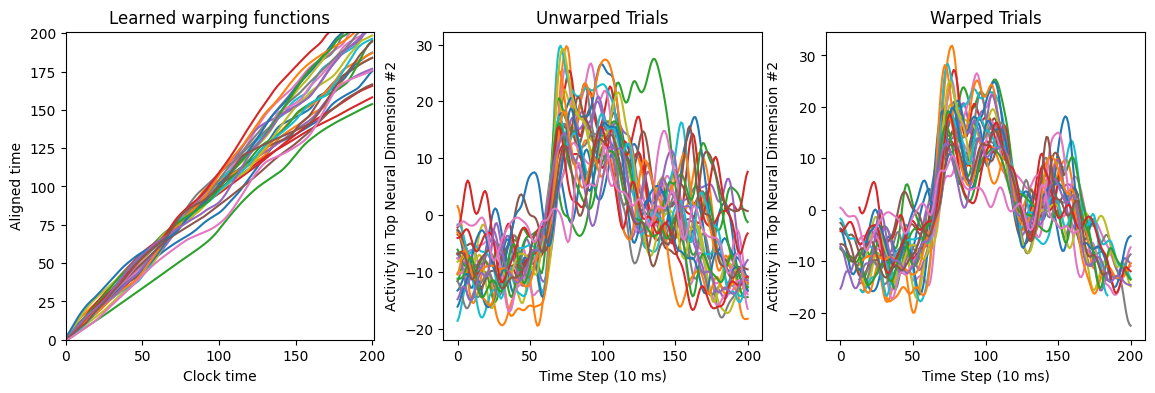

Warping character: l


/var/folders/n_/8p1gdnb570j4m06ltsyf5d1w0000gn/T/ipykernel_77119/1300111360.py:54: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  smoothed_spikes = scipy.ndimage.filters.gaussian_filter1d(dat['neuralActivityCube_'+char], 3.0, axis=1)
2025-06-17 11:56:27.709421: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_scale_79/Assign' id:2077044 op device:{requested: '', assigned: ''} def:{{{node tau_scale_79/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](tau_scale_79, tau_scale_79/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-17 11:58:06.113734: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_shift_79/A

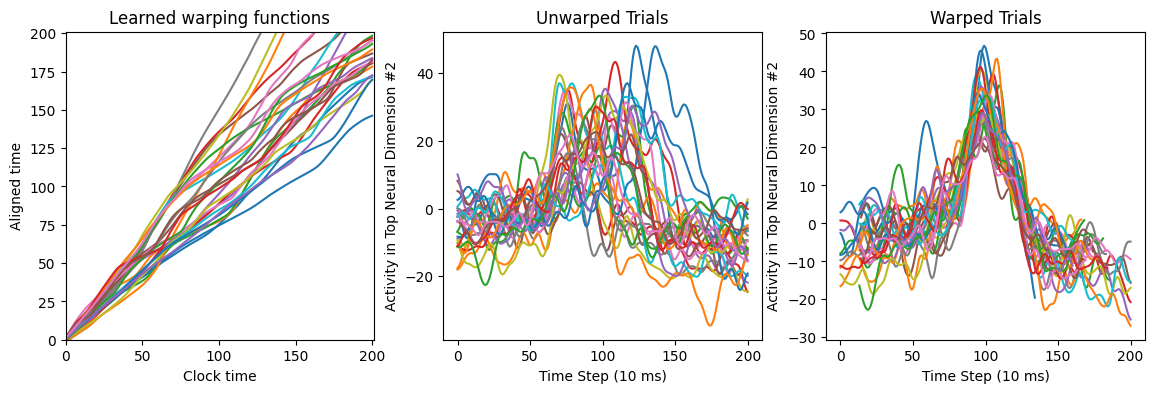

Warping character: m


/var/folders/n_/8p1gdnb570j4m06ltsyf5d1w0000gn/T/ipykernel_77119/1300111360.py:54: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  smoothed_spikes = scipy.ndimage.filters.gaussian_filter1d(dat['neuralActivityCube_'+char], 3.0, axis=1)
2025-06-17 12:01:20.435464: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_scale_80/Assign' id:2106146 op device:{requested: '', assigned: ''} def:{{{node tau_scale_80/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](tau_scale_80, tau_scale_80/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-17 12:03:24.830842: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_shift_80/A

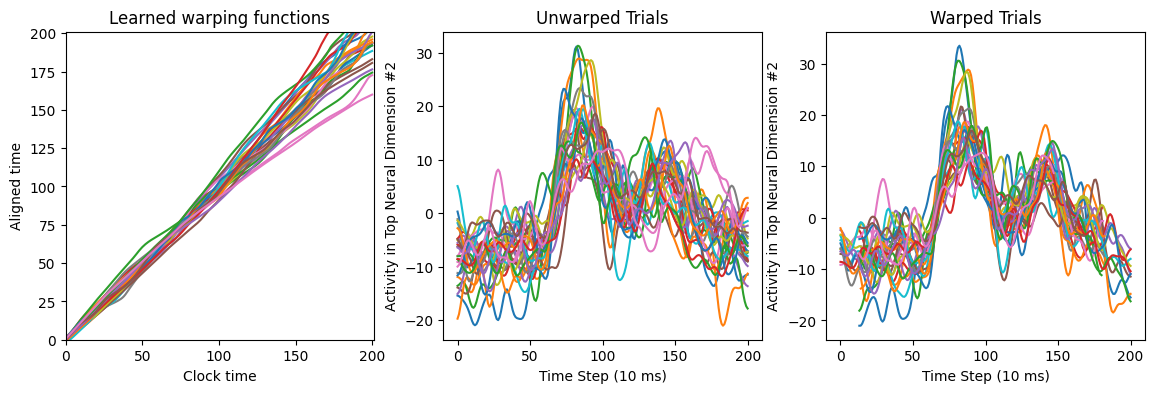

Warping character: n


/var/folders/n_/8p1gdnb570j4m06ltsyf5d1w0000gn/T/ipykernel_77119/1300111360.py:54: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  smoothed_spikes = scipy.ndimage.filters.gaussian_filter1d(dat['neuralActivityCube_'+char], 3.0, axis=1)
2025-06-17 12:06:44.738903: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_scale_81/Assign' id:2135299 op device:{requested: '', assigned: ''} def:{{{node tau_scale_81/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](tau_scale_81, tau_scale_81/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-17 12:08:26.926281: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_shift_81/A

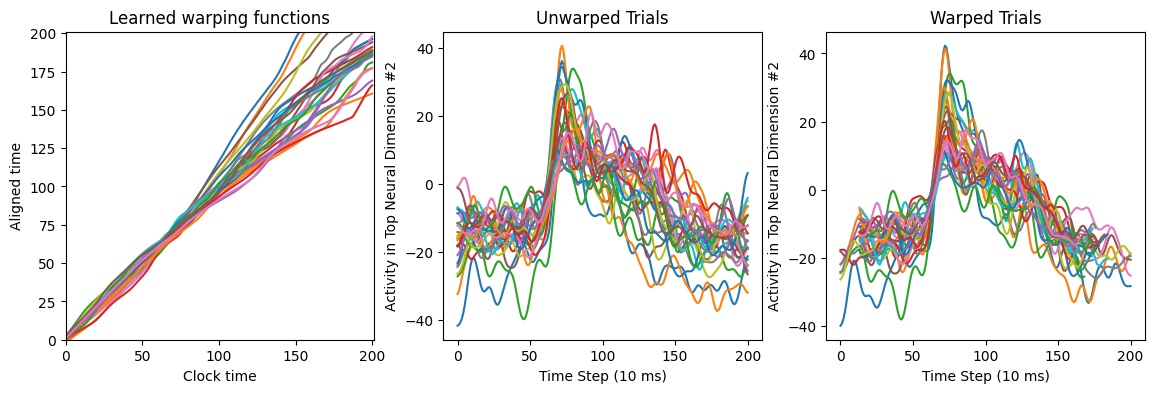

Warping character: o


/var/folders/n_/8p1gdnb570j4m06ltsyf5d1w0000gn/T/ipykernel_77119/1300111360.py:54: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  smoothed_spikes = scipy.ndimage.filters.gaussian_filter1d(dat['neuralActivityCube_'+char], 3.0, axis=1)
2025-06-17 12:11:34.013044: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_scale_82/Assign' id:2164503 op device:{requested: '', assigned: ''} def:{{{node tau_scale_82/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](tau_scale_82, tau_scale_82/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-17 12:13:20.798729: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_shift_82/A

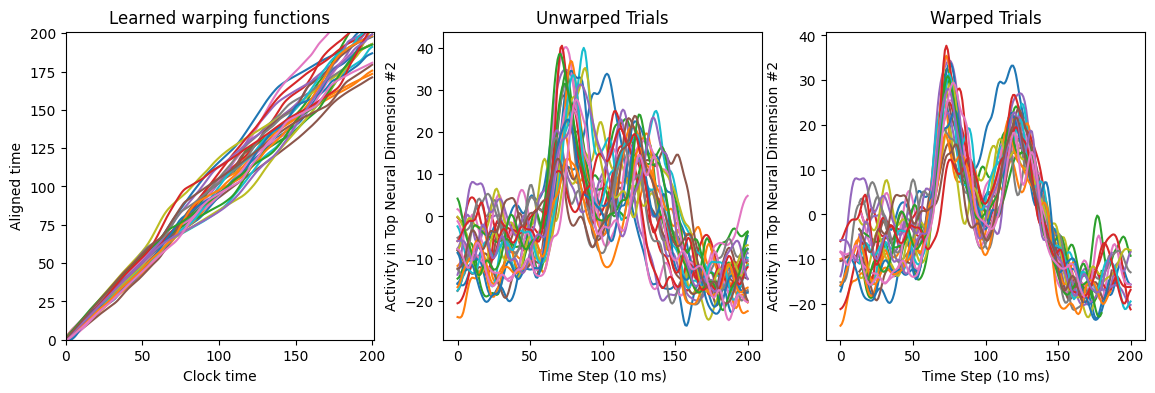

Warping character: p


/var/folders/n_/8p1gdnb570j4m06ltsyf5d1w0000gn/T/ipykernel_77119/1300111360.py:54: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  smoothed_spikes = scipy.ndimage.filters.gaussian_filter1d(dat['neuralActivityCube_'+char], 3.0, axis=1)
2025-06-17 12:16:18.214286: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_scale_83/Assign' id:2193758 op device:{requested: '', assigned: ''} def:{{{node tau_scale_83/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](tau_scale_83, tau_scale_83/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-17 12:17:51.959813: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_shift_83/A

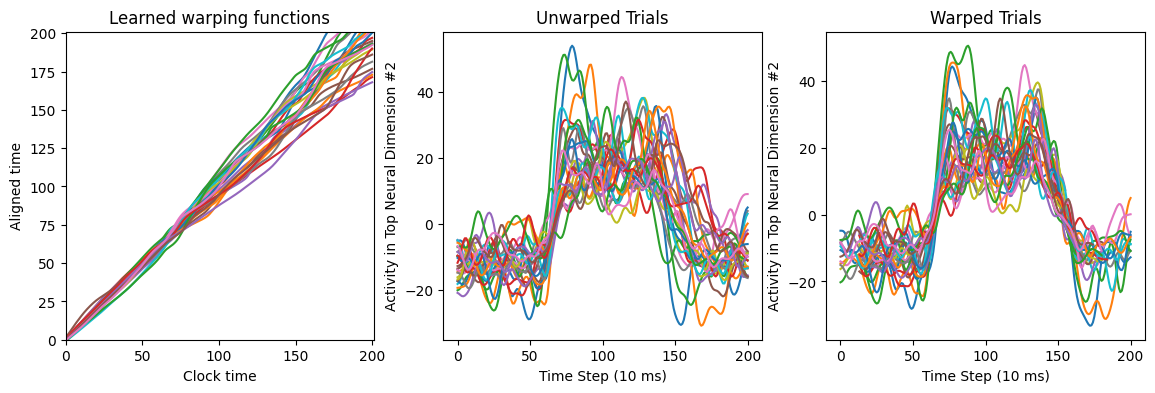

Warping character: q


/var/folders/n_/8p1gdnb570j4m06ltsyf5d1w0000gn/T/ipykernel_77119/1300111360.py:54: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  smoothed_spikes = scipy.ndimage.filters.gaussian_filter1d(dat['neuralActivityCube_'+char], 3.0, axis=1)
2025-06-17 12:20:53.224702: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_scale_84/Assign' id:2223064 op device:{requested: '', assigned: ''} def:{{{node tau_scale_84/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](tau_scale_84, tau_scale_84/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-17 12:22:31.606976: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_shift_84/A

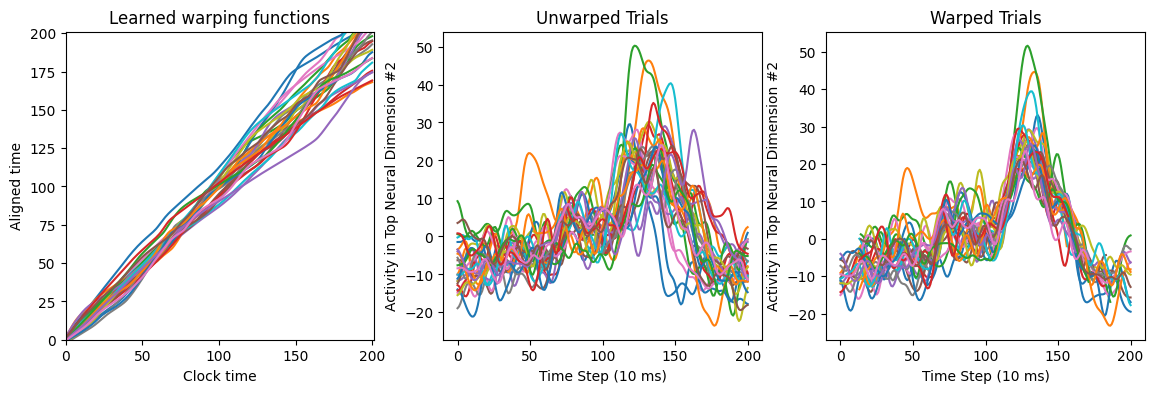

Warping character: r


/var/folders/n_/8p1gdnb570j4m06ltsyf5d1w0000gn/T/ipykernel_77119/1300111360.py:54: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  smoothed_spikes = scipy.ndimage.filters.gaussian_filter1d(dat['neuralActivityCube_'+char], 3.0, axis=1)
2025-06-17 12:36:17.363201: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_scale_85/Assign' id:2252421 op device:{requested: '', assigned: ''} def:{{{node tau_scale_85/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](tau_scale_85, tau_scale_85/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-17 12:38:07.100795: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_shift_85/A

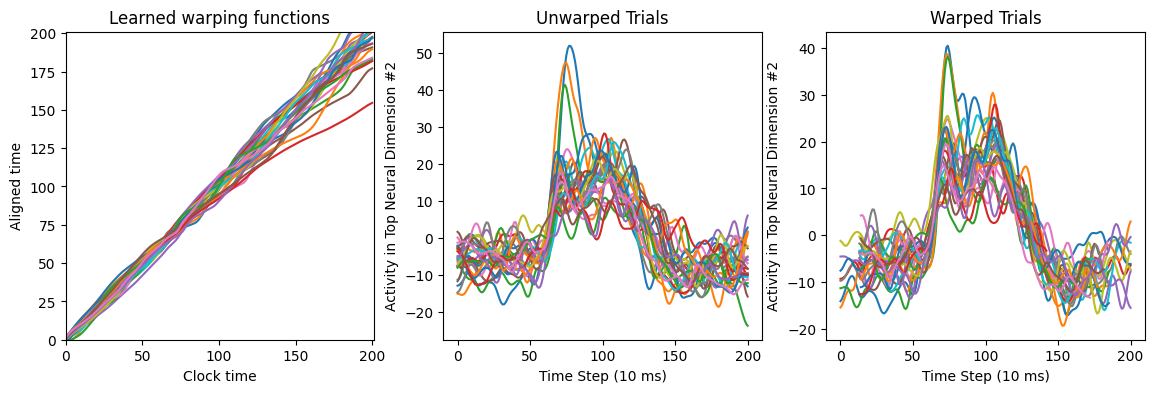

Warping character: s


/var/folders/n_/8p1gdnb570j4m06ltsyf5d1w0000gn/T/ipykernel_77119/1300111360.py:54: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  smoothed_spikes = scipy.ndimage.filters.gaussian_filter1d(dat['neuralActivityCube_'+char], 3.0, axis=1)
2025-06-17 12:41:35.611837: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_scale_86/Assign' id:2281829 op device:{requested: '', assigned: ''} def:{{{node tau_scale_86/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](tau_scale_86, tau_scale_86/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-17 12:43:31.725807: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_shift_86/A

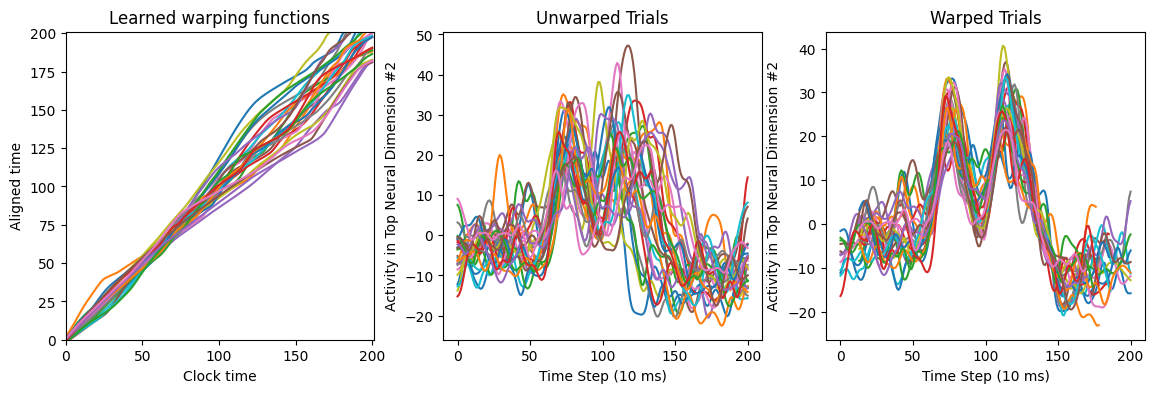

Warping character: t


/var/folders/n_/8p1gdnb570j4m06ltsyf5d1w0000gn/T/ipykernel_77119/1300111360.py:54: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  smoothed_spikes = scipy.ndimage.filters.gaussian_filter1d(dat['neuralActivityCube_'+char], 3.0, axis=1)
2025-06-17 12:47:12.592702: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_scale_87/Assign' id:2311288 op device:{requested: '', assigned: ''} def:{{{node tau_scale_87/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](tau_scale_87, tau_scale_87/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-17 12:49:13.329021: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_shift_87/A

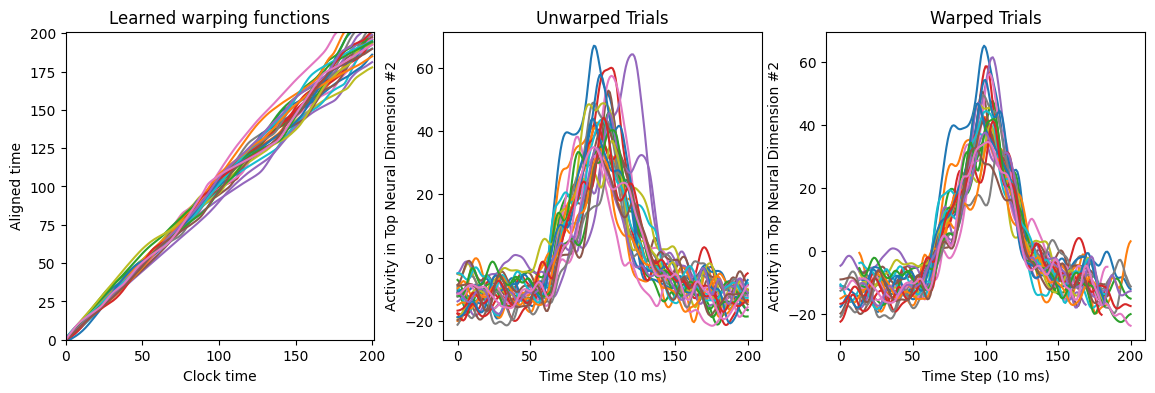

Warping character: u


/var/folders/n_/8p1gdnb570j4m06ltsyf5d1w0000gn/T/ipykernel_77119/1300111360.py:54: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  smoothed_spikes = scipy.ndimage.filters.gaussian_filter1d(dat['neuralActivityCube_'+char], 3.0, axis=1)
2025-06-17 12:52:53.667416: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_scale_88/Assign' id:2340798 op device:{requested: '', assigned: ''} def:{{{node tau_scale_88/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](tau_scale_88, tau_scale_88/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-17 12:54:44.801607: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_shift_88/A

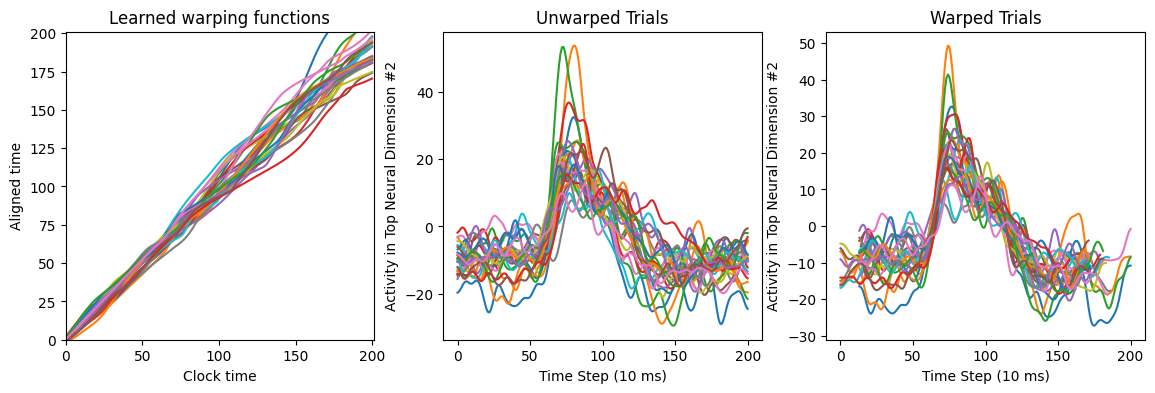

Warping character: v


/var/folders/n_/8p1gdnb570j4m06ltsyf5d1w0000gn/T/ipykernel_77119/1300111360.py:54: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  smoothed_spikes = scipy.ndimage.filters.gaussian_filter1d(dat['neuralActivityCube_'+char], 3.0, axis=1)
2025-06-17 12:58:15.719687: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_scale_89/Assign' id:2370359 op device:{requested: '', assigned: ''} def:{{{node tau_scale_89/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](tau_scale_89, tau_scale_89/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-17 13:00:08.317114: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_shift_89/A

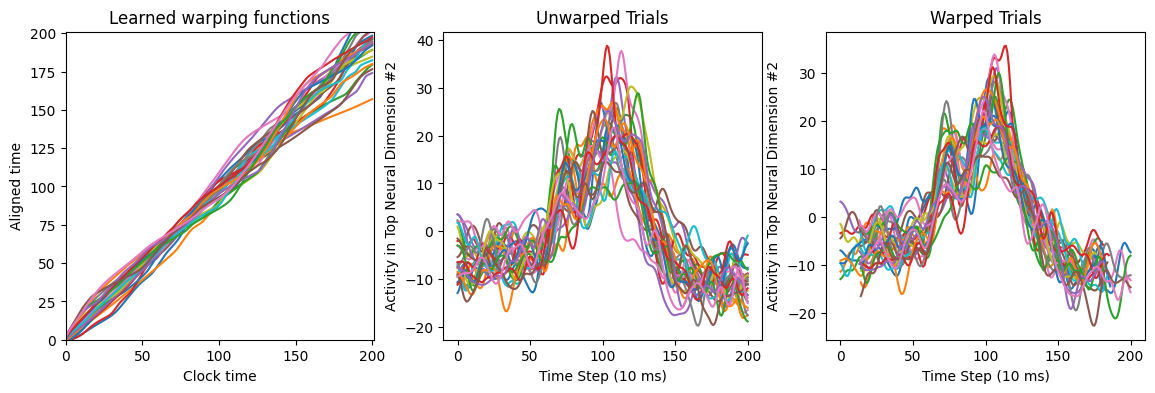

Warping character: w


/var/folders/n_/8p1gdnb570j4m06ltsyf5d1w0000gn/T/ipykernel_77119/1300111360.py:54: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  smoothed_spikes = scipy.ndimage.filters.gaussian_filter1d(dat['neuralActivityCube_'+char], 3.0, axis=1)
2025-06-17 13:03:34.290720: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_scale_90/Assign' id:2399971 op device:{requested: '', assigned: ''} def:{{{node tau_scale_90/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](tau_scale_90, tau_scale_90/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-17 13:05:34.334452: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_shift_90/A

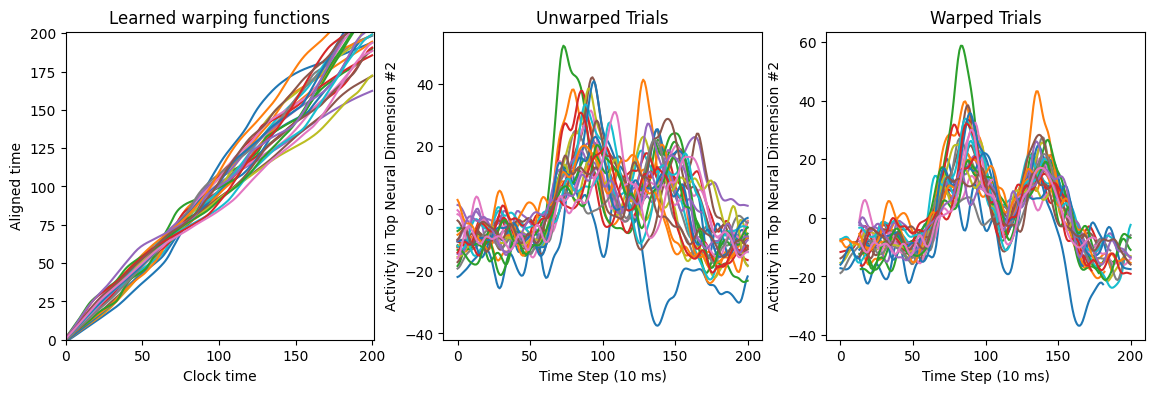

Warping character: x


/var/folders/n_/8p1gdnb570j4m06ltsyf5d1w0000gn/T/ipykernel_77119/1300111360.py:54: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  smoothed_spikes = scipy.ndimage.filters.gaussian_filter1d(dat['neuralActivityCube_'+char], 3.0, axis=1)
2025-06-17 13:09:07.077496: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_scale_91/Assign' id:2429634 op device:{requested: '', assigned: ''} def:{{{node tau_scale_91/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](tau_scale_91, tau_scale_91/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-17 13:11:12.226988: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_shift_91/A

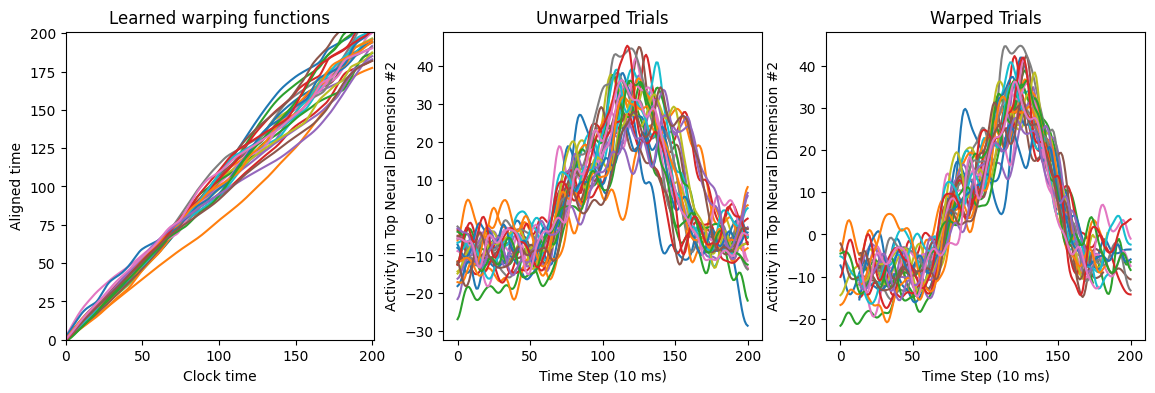

Warping character: y


/var/folders/n_/8p1gdnb570j4m06ltsyf5d1w0000gn/T/ipykernel_77119/1300111360.py:54: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  smoothed_spikes = scipy.ndimage.filters.gaussian_filter1d(dat['neuralActivityCube_'+char], 3.0, axis=1)
2025-06-17 13:15:12.281704: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_scale_92/Assign' id:2459348 op device:{requested: '', assigned: ''} def:{{{node tau_scale_92/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](tau_scale_92, tau_scale_92/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-17 13:17:14.077956: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_shift_92/A

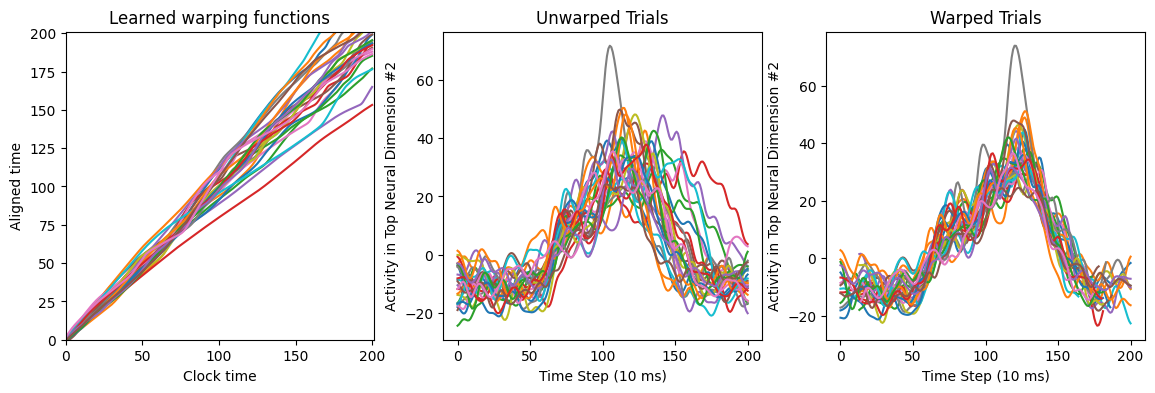

Warping character: z


/var/folders/n_/8p1gdnb570j4m06ltsyf5d1w0000gn/T/ipykernel_77119/1300111360.py:54: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  smoothed_spikes = scipy.ndimage.filters.gaussian_filter1d(dat['neuralActivityCube_'+char], 3.0, axis=1)
2025-06-17 13:21:10.601275: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_scale_93/Assign' id:2489113 op device:{requested: '', assigned: ''} def:{{{node tau_scale_93/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](tau_scale_93, tau_scale_93/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-17 13:23:31.528034: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_shift_93/A

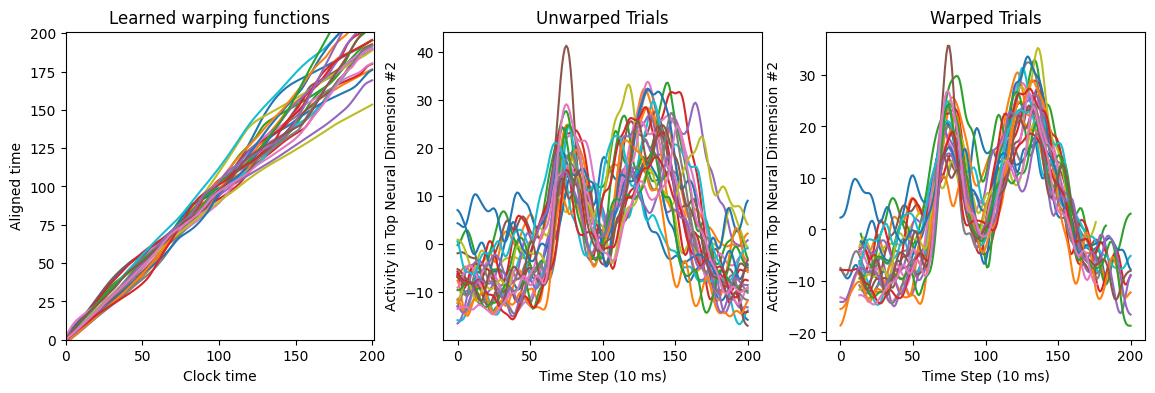

Warping character: greaterThan


/var/folders/n_/8p1gdnb570j4m06ltsyf5d1w0000gn/T/ipykernel_77119/1300111360.py:54: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  smoothed_spikes = scipy.ndimage.filters.gaussian_filter1d(dat['neuralActivityCube_'+char], 3.0, axis=1)
2025-06-17 13:27:41.054707: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_scale_94/Assign' id:2518929 op device:{requested: '', assigned: ''} def:{{{node tau_scale_94/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](tau_scale_94, tau_scale_94/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-17 13:29:53.136521: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_shift_94/A

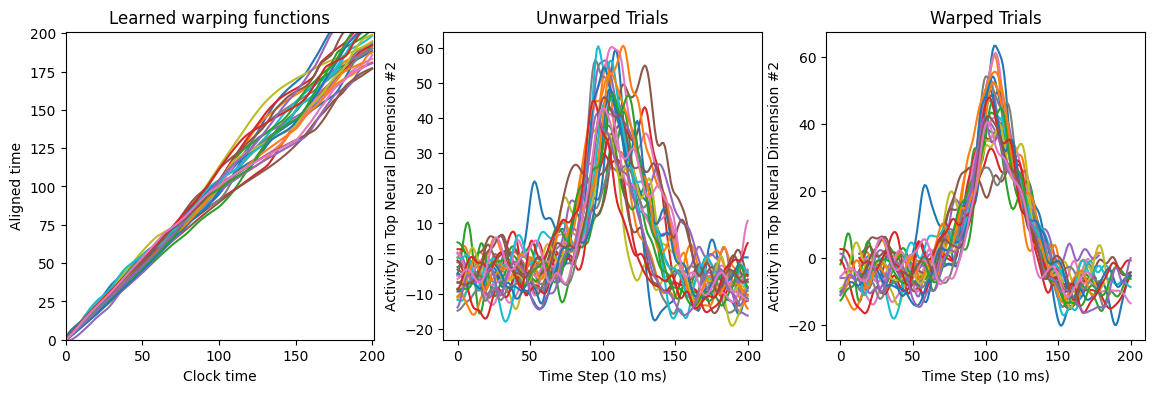

Warping character: comma


/var/folders/n_/8p1gdnb570j4m06ltsyf5d1w0000gn/T/ipykernel_77119/1300111360.py:54: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  smoothed_spikes = scipy.ndimage.filters.gaussian_filter1d(dat['neuralActivityCube_'+char], 3.0, axis=1)
2025-06-17 13:34:11.451094: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_scale_95/Assign' id:2548796 op device:{requested: '', assigned: ''} def:{{{node tau_scale_95/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](tau_scale_95, tau_scale_95/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-17 13:36:27.983692: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_shift_95/A

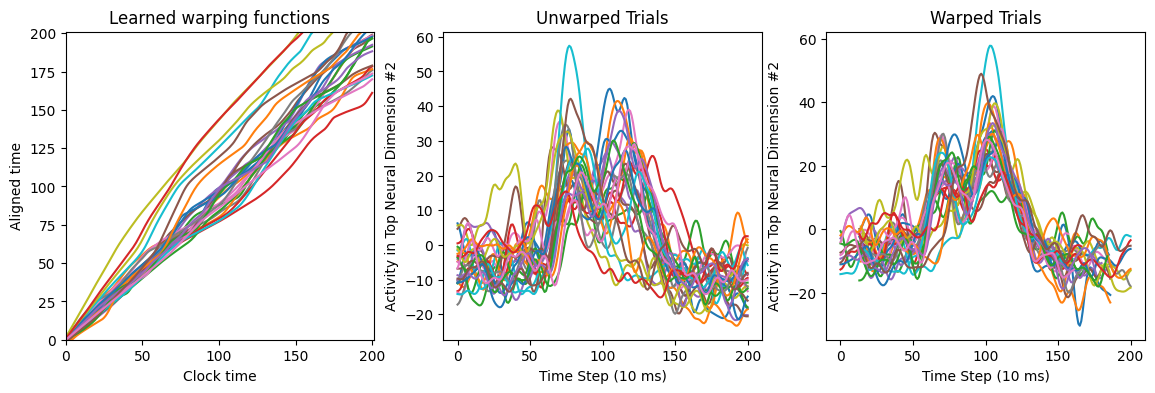

Warping character: apostrophe


/var/folders/n_/8p1gdnb570j4m06ltsyf5d1w0000gn/T/ipykernel_77119/1300111360.py:54: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  smoothed_spikes = scipy.ndimage.filters.gaussian_filter1d(dat['neuralActivityCube_'+char], 3.0, axis=1)
2025-06-17 13:41:07.179932: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_scale_96/Assign' id:2578714 op device:{requested: '', assigned: ''} def:{{{node tau_scale_96/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](tau_scale_96, tau_scale_96/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-17 13:43:37.999540: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_shift_96/A

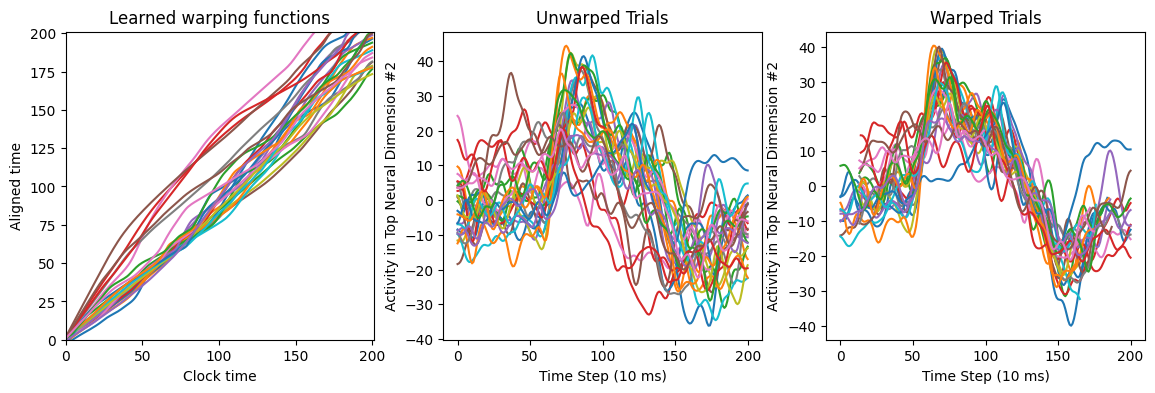

Warping character: tilde


/var/folders/n_/8p1gdnb570j4m06ltsyf5d1w0000gn/T/ipykernel_77119/1300111360.py:54: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  smoothed_spikes = scipy.ndimage.filters.gaussian_filter1d(dat['neuralActivityCube_'+char], 3.0, axis=1)
2025-06-17 13:58:40.045959: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_scale_97/Assign' id:2608683 op device:{requested: '', assigned: ''} def:{{{node tau_scale_97/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](tau_scale_97, tau_scale_97/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-17 14:01:34.026869: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_shift_97/A

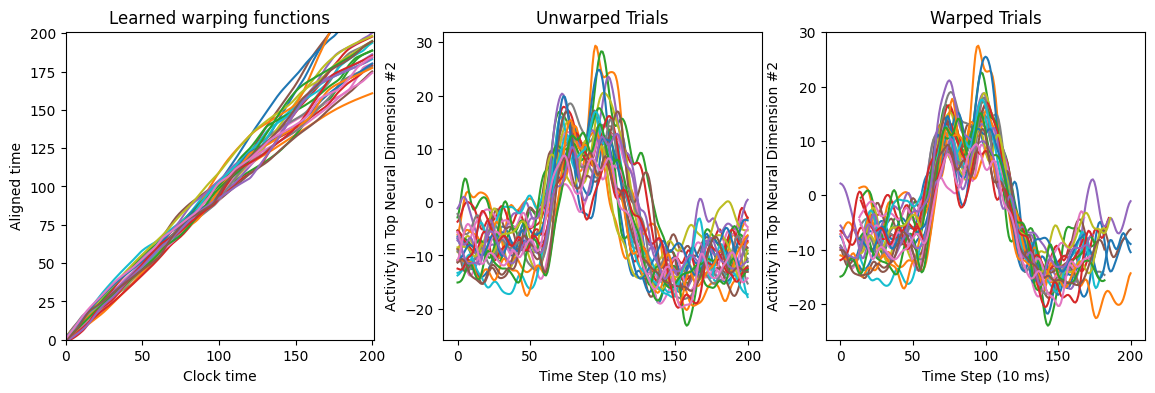

Warping character: questionMark


/var/folders/n_/8p1gdnb570j4m06ltsyf5d1w0000gn/T/ipykernel_77119/1300111360.py:54: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  smoothed_spikes = scipy.ndimage.filters.gaussian_filter1d(dat['neuralActivityCube_'+char], 3.0, axis=1)
2025-06-17 14:06:27.686162: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_scale_98/Assign' id:2638703 op device:{requested: '', assigned: ''} def:{{{node tau_scale_98/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](tau_scale_98, tau_scale_98/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-17 14:09:06.749140: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_shift_98/A

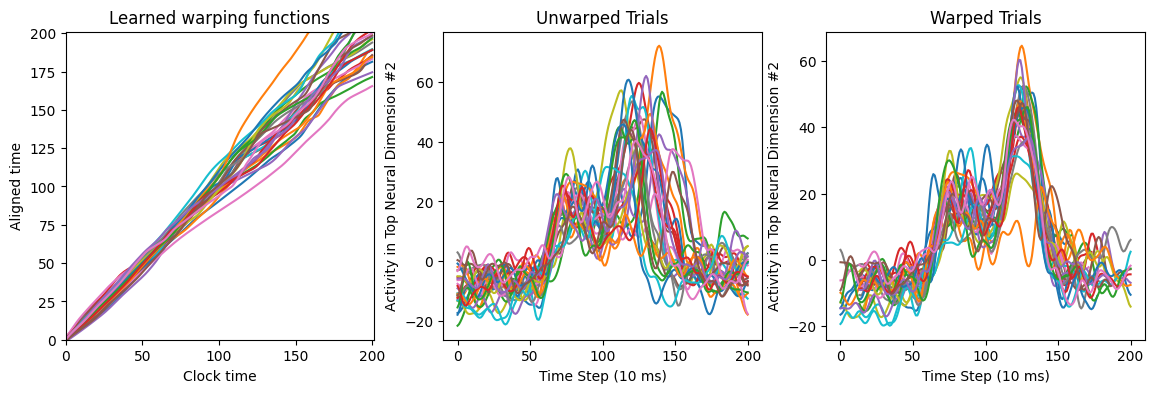

Saving /Users/seanmacpherson/clones/willets-2021-handwriting-bci/warped-data/_warpedCubes.mat


In [39]:
#Time-warp all singleLetters.mat files and save them to the Step1_TimeWarping folder
for dataDir in dataDirs:
    
    print('Warping dataset: ' + dataDir)
    #Because baseline firing rates drift over time, we normalize each electrode's firing rate by subtracting
    #its mean firing rate within each block of data (re-centering it). We also divide by each electrode's standard deviation 
    #to normalize the units.
    for idx, char in enumerate(charDef['charList']):
        neuralCube = dat['neuralActivityCube_'+char].astype(np.float64)

        #get the trials that belong to this character
        trlIdx = []
        for t in range(dat['characterCues'].shape[0]):
            if dat['characterCues'][t,0]==char:
                trlIdx.append(t)

        #get the block that each trial belonged to
        blockIdx = dat['blockNumsTimeSeries'][dat['goPeriodOnsetTimeBin'][trlIdx]]
        blockIdx = np.squeeze(blockIdx)

        #subtract block-specific means from each trial 
        for b in range(dat['blockList'].shape[0]):
            trialsFromThisBlock = np.squeeze(blockIdx==dat['blockList'][b])
            neuralCube[trialsFromThisBlock,:,:] -= dat['meansPerBlock'][np.newaxis,b,:]

        #divide by standard deviation to normalize the units
        neuralCube = neuralCube / dat['stdAcrossAllData'][np.newaxis,:,:]

        #replace the original cube with this newly normalized one
        dat['neuralActivityCube_'+char] = neuralCube
    
    alignedDat = {}

    #The following warps each character one at a time. 
    #(this is slow, and could be sped up significantly by warping multiple characters in parallel)
    for idx, char in enumerate(charDef['charList']):
        print('Warping character: ' + char)

        #Clears the previous character's graph
        # tf.reset_default_graph()

        #Number of factors used to denoise the data while time-warping (by approximating data with low-rank matrices)
        n_components = 5

        #Adds an L1 penalty on the second order finite difference of the warping functions.
        #This encourages the warping functions to be piecewise linear.
        warp_regularizer = curvature(scale=0.001, power=1)

        #Adds an L2 penatly on the second order finite difference of the temporal factors.
        #Encourages the temporal factors to be smooth in time.
        time_regularizer = curvature(scale=1.0, power=2, axis=0)

        # Smooths the binned spike counts before time-warping to denoise them (this step is key!)
        smoothed_spikes = scipy.ndimage.filters.gaussian_filter1d(dat['neuralActivityCube_'+char], 3.0, axis=1)

        # fit time-warping model
        model = TWPCA(smoothed_spikes, 
                      n_components, 
                      warp_regularizer=warp_regularizer, 
                      time_regularizer=time_regularizer).fit(progressbar=False)

        # use the model object to align data 
        estimated_aligned_data = model.transform(dat['neuralActivityCube_'+char])
        smoothed_aligned_data = scipy.ndimage.filters.gaussian_filter1d(estimated_aligned_data, 3.0, axis=1)

        #store aligned data and time-warping functions
        alignedDat[char] = estimated_aligned_data
        alignedDat[char+'_T'] = model.params['warp'].T.copy()

        #only make plots for the first session (otherwise the notebook gets too big)
        if dataDir!='t5.2019.05.08':
            continue
            
        #plot the warping functions to make sure they look reasonable (should be subtle deviations from the identity line)
        plt.figure(figsize=(14,4))
        plt.subplot(1,3,1)
        plt.plot(model.params['warp'].T, alpha=1);
        plt.axis('square')
        plt.xlabel('Clock time')
        plt.ylabel('Aligned time')
        plt.xlim(0, model.params['warp'].T.shape[0]);
        plt.ylim(0, model.params['warp'].T.shape[0])
        plt.title('Learned warping functions')
        
        #It's helpful also to visualize how the major dimensions in the data were aligned
        #We chose dimension 2 here, because the top dimension isn't as informative (it's just a large spike at movement onset)
        neuron_factors = model.params['neuron']
        plt.subplot(1,3,2)
        for t in range(estimated_aligned_data.shape[0]):
            thisTrialActivity = np.matmul(smoothed_spikes[t,:,:], neuron_factors)
            plt.plot(thisTrialActivity[:,1])

        plt.title('Unwarped Trials')
        plt.xlabel('Time Step (10 ms)')
        plt.ylabel('Activity in Top Neural Dimension #2')
        
        plt.subplot(1,3,3)
        for t in range(estimated_aligned_data.shape[0]):
            thisTrialWarpedActivity = np.matmul(smoothed_aligned_data[t,:,:], neuron_factors)
            plt.plot(thisTrialWarpedActivity[:,1])
        
        plt.title('Warped Trials')
        plt.xlabel('Time Step (10 ms)')
        plt.ylabel('Activity in Top Neural Dimension #2')
        
        plt.show()

    #save time-warped characters as a .mat file        
    fileName = rootDir + '/warped-data' + '/_warpedCubes.mat'
    print('Saving ' + fileName)
    scipy.io.savemat(fileName, alignedDat)